# House Prices - Advanced Regression Techniques Solution

In this notebook, we will build a machine learning model to predict house prices based on various features.

### Steps:
1. Load and explore the data with visualizations.
2. Data cleaning and preprocessing.
3. Feature engineering.
4. Model training and evaluation using multiple algorithms.
5. Final predictions and preparation of the submission file.


##  Load and Explore the Data



In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load train and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Display first few rows of the dataset
train_df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


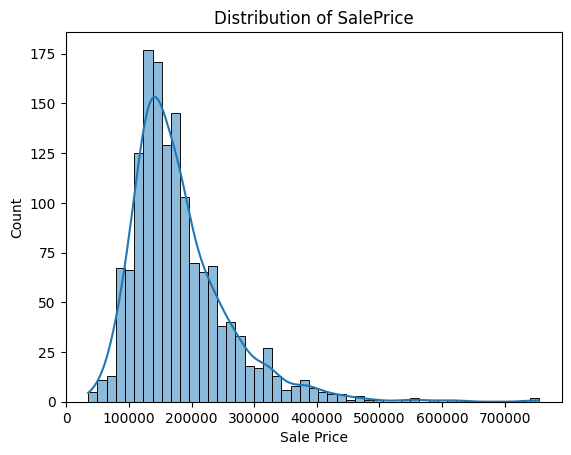

In [39]:
# Plot the distribution of SalePrice
sns.histplot(train_df['SalePrice'], kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("Sale Price")
plt.show()


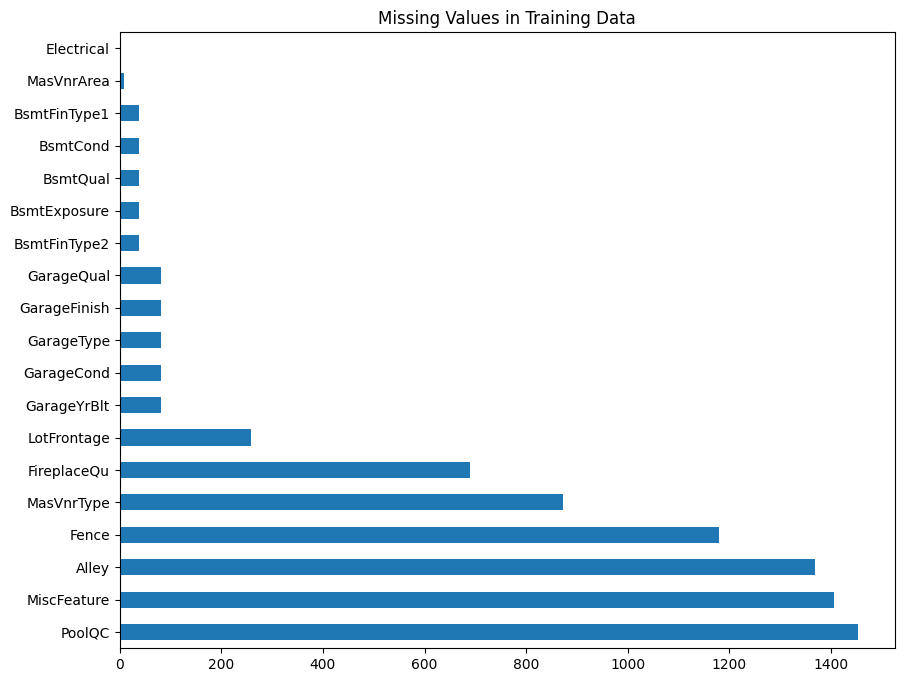

In [40]:
# Checking for missing values
missing_values = train_df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
missing_values.plot(kind="barh", figsize=(10,8))
plt.title("Missing Values in Training Data")
plt.show()


##  Data Preprocessing

In [41]:
from sklearn.preprocessing import LabelEncoder

# Concatenate train and test data for consistent preprocessing
all_data = pd.concat([train_df, test_df], sort=False)

# Fill missing values for numerical columns with median values
all_data['LotFrontage'] = all_data['LotFrontage'].fillna(all_data['LotFrontage'].median())

# Fill missing values in categorical columns with 'None'
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[col] = all_data[col].fillna('None')

# Label encode categorical variables
label = LabelEncoder()
for col in all_data.select_dtypes(include=['object']).columns:
    all_data[col] = label.fit_transform(all_data[col].astype(str))

# Separate back into train and test sets
train_df = all_data[:len(train_df)]
test_df = all_data[len(train_df):]


##Feature engineering

In [42]:
import numpy as np

# Log transform skewed target variable
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# Create new feature: TotalSquareFeet
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']


<ipython-input-42-61163438017f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
<ipython-input-42-61163438017f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
<ipython-input-42-61163438017f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [43]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
best_model = None
best_rmse = 10  # Start with a realistic RMSE threshold, instead of infinity

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"{model_name} RMSE: {rmse:.4f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model

# Check if best_model was selected; assign default if not
if best_model is None:
    print("No model met the best RMSE threshold. Using Random Forest as default model.")
    best_model = RandomForestRegressor(n_estimators=100, random_state=42)
    best_model.fit(X, y)  # Train on the full training set


Linear Regression RMSE: 0.1553
Random Forest RMSE: 0.1455
Gradient Boosting RMSE: 0.1373
XGBoost RMSE: 0.1421


## Final Prediction and Submission

In [44]:
# Re-check and impute NaNs in X_test
X_test = test_df.drop(['Id'], axis=1)
# Impute missing values using the median of the training data (X_train)
# Convert X_train to a DataFrame with the same columns as X_test for easier indexing

# Get columns present in both X_train and X_test
common_cols = X_train.shape[1]  # Assuming all columns except 'Id' are common
X_train_df = pd.DataFrame(X_train, columns=X_test.columns[:common_cols]) # Convert X_train to DataFrame using common columns

# Ensure both X_test and X_train_df have the same columns (for imputation)
X_test = X_test[X_train_df.columns]

for column in X_test.columns:
    # Check if the column has any missing values
    if X_test[column].isnull().any():
        # If yes, fill missing values with the median from the training data
        X_test[column] = X_test[column].fillna(X_train_df[column].median())  # Use X_train_df for indexing

# Use best model to predict on the test set
test_pred = best_model.predict(X_test)
test_pred = np.expm1(test_pred)  # Inverse log transformation to get original scale

# Prepare submission file
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': test_pred
})

# Save to CSV for submission
submission.to_csv('submission.csv', index=False)
submission.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


,Id,SalePrice
0,1461,139092.516731
1,1462,155195.340772
2,1463,179317.130409
3,1464,187859.122888
4,1465,176589.371859
